In [1]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.ticker import AutoMinorLocator
import matplotlib.animation as animation
from matplotlib.animation import ArtistAnimation, PillowWriter
import warnings
from astropy.io import ascii
from astropy.table import Table
from astropy import units as u
from astropy.visualization import quantity_support
from astropy.units import imperial
imperial.enable()

# Problem 1: Project Update
1. Accessed the UTSA ARC Computer Cluster, runs way better able to 'leapfrog' solve our differential equation
2. Checking effects on Convservation of Energy for simulation
3. Nate is polishing off some momentum and center of mass movement analysis
4. When I chose this project, i really felt that it would be `cool` but now it just feels boring.

In [2]:
#download files & ignore warnings
!wget https://raw.githubusercontent.com/thaynecurrie/phys7943_fall2023/main/ScientificPythonNotes/Astropy/code/sect1/files/keckimage.fits
!wget https://raw.githubusercontent.com/thaynecurrie/phys7943_fall2023/main/ScientificPythonNotes/Astropy/code/sect1/files/adi_oct172021.fits
!wget https://raw.githubusercontent.com/thaynecurrie/phys7943_fall2023/main/ScientificPythonNotes/Astropy/code/sect1/files/asdicomb_indiv.fits
!wget https://raw.githubusercontent.com/thaynecurrie/phys7943_fall2023/main/ScientificPythonNotes/Astropy/code/sect2/files/leggett.txt

#turn off warnings for blank headers in fits
warnings.filterwarnings('ignore')


--2023-11-16 00:50:30--  https://raw.githubusercontent.com/thaynecurrie/phys7943_fall2023/main/ScientificPythonNotes/Astropy/code/sect1/files/keckimage.fits
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1074240 (1.0M) [application/octet-stream]
Saving to: ‘keckimage.fits’

keckimage.fits      100%[===================>]   1.02M  --.-KB/s    in 0.04s   

2023-11-16 00:50:30 (25.0 MB/s) - ‘keckimage.fits’ saved [1074240/1074240]

--2023-11-16 00:50:30--  https://raw.githubusercontent.com/thaynecurrie/phys7943_fall2023/main/ScientificPythonNotes/Astropy/code/sect1/files/adi_oct172021.fits
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubu

#Problem 2: Reading in Fits
1. uses with fits to read in `keckimage.fits`
2. known header names called and stored to var
3. uses numpy for dim
4. uses astropy to return dim

In [3]:
#open file
with fits.open('keckimage.fits') as hdul:
    image_data = hdul[0].data
    header = hdul[0].header


    altitude = header['ALTITUDE']
    azimuth = header['AZIMUTH']

    #print altitude and azimuth
    print(f'Altitude: {altitude}')
    print(f'Azimuth: {azimuth}')

    #numpy call for dim
    numpy_dimension = image_data.shape
    print(f'Numpy Dimension Call/Image Size : {numpy_dimension}')

    #same array but read in shape of 0
    astropy_dimension = hdul[0].shape
    print(f'Astropy Dimension Call/Image Size: {astropy_dimension}')


Altitude: 65.39478
Azimuth: 3.43391
Numpy Dimension Call/Image Size : (512, 512)
Astropy Dimension Call/Image Size: (512, 512)


#Problem 3: Still Reading in Fits
1. uses with fits.open
2. Index at 0, access slice 1
3. y/x pixel value
4. use hdul[1] for data, pass it y/x in the 10th slice (9)
5. returns aperture_raidus at r_ap2


In [4]:
#open fits file
with fits.open('adi_oct172021.fits') as hdul:

    #found apeture radius: R_AP3-1 -> R_AP2
    aperture_radius = hdul[1].header.get('R_AP2')
    print(f'Aperture Radius for the third slice: {aperture_radius}')

    #set given pixel values
    y_px = 79
    x_px = 82

    pixel_value = hdul[1].data[9, y_px, x_px]
    print(f'Pixel Value at 10th slice [x={x_px}, y={y_px}]: {pixel_value}')

    flux_density_units = hdul[1].header.get('FLUXUNIT')
    print(f'Flux Density Units: {flux_density_units}')

Aperture Radius for the third slice: 1.00023594697
Pixel Value at 10th slice [x=82, y=79]: 0.02506706491112709
Flux Density Units: mJy


#Problem 4: Writing Fits Files
1. Read/open `adi_oct172021.fits`
2. Calculate median image across all the wavelengths
3. create a new primary hdu using the calculated median image
4. write to new file with meadian_ prefix

In [5]:
#open fits file
with fits.open('adi_oct172021.fits') as hdul:
    #calculate median along all wavelength/slices
    median_image = np.median(hdul[1].data, axis=0)

    #new primary hdu for median image
    hdu_median = fits.PrimaryHDU(data=median_image, header=hdul[1].header)

    # Write the median image to a new FITS file
    hdu_median.writeto('median_adi_oct172021.fits')
    print('Saved Sucesfully!')


Saved Sucesfully!


# Problem 5: Grad Students Only
1. set values called `vertical_offset` and `horizontal_offset` for the display of the wavelength slice parameter that I will add
2. Uncommented Title that was in source code
3. Added wavelength counter & adjusted z order. Also passed offset parameters defined as `counter`
4. passed `counter` to immovie
5. Defined in functions, called in cell below

In [6]:
import matplotlib as mpl

#set parameters
rmax = 0.9
pixelscale = 0.01615
extrange = [rmax, -1 * rmax, -1 * rmax, rmax]
data_cube = (fits.open('asdicomb_indiv.fits'))[0].data


#wavelength slice params
vertical_offset = 0.05  #fraction of height from bottom
horizontal_offset = 0.2  #fraction from left

def create_colormap(cmap_name):
    R, G, B, A = mpl.cm.get_cmap(cmap_name)(np.linspace(0.0, 1.0, 256)).T
    color_vals = np.array([B, G, R, A]).T
    cmap = mpl.colors.ListedColormap(color_vals)
    cmap.set_bad('k')
    return cmap

def setup_plot(rmax, pixelscale, data_shape):
    fig, axes = plt.subplots(figsize=(9, 9))
    fullext_image = pixelscale * data_shape[1] / 2.0

    axes.set_xlim(rmax, -1 * rmax)
    axes.set_ylim(-1 * rmax, rmax)
    axes.tick_params(which='both', direction='out', labelsize=14)
    axes.tick_params(which='major', length=10, width=1.5)
    axes.tick_params(which='minor', length=5, width=1.5)
    axes.xaxis.set_minor_locator(AutoMinorLocator(5))
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    axes.set_xlabel('$\Delta RA(^{\prime\prime})$', fontsize=16)
    axes.set_ylabel('$\Delta DEC(^{\prime\prime})$', fontsize=16)
    axes.text(0.95*rmax, 0.85*rmax, 'Exoplanet HIP 99770 b\nSCExAO/CHARIS', fontsize=16, color='w')
    axes.scatter(0, 0, marker='*', c='yellow', edgecolor='black', s=500)

    return fig, axes, fullext_image

def create_animation(fig, axes, data_cube, cmapval, rmax, fullext_image, vertical_offset, horizontal_offset):
    immovie = []
    n_lambda = data_cube.shape[0]  #total wavelength slices

    for i in range(n_lambda):
        #color scale limits based on sampled data
        climsp = np.nanpercentile(data_cube[i, :, :], [0, 99.9])
        clims = [-1.5 * climsp[1], climsp[1]]
        interpval = 'hanning'

        #display data
        im = axes.imshow(data_cube[i, :, :], animated=True, clim=clims, origin='lower',
                 extent=[fullext_image, -1 * fullext_image, -1 * fullext_image, fullext_image],
                 interpolation=interpval, cmap=cmapval)


        #add text for each frame using the offsets changing zorder
        counter = axes.text(horizontal_offset, vertical_offset, f'Wavelength Slice {i+1}',
                            fontsize=16, color='white', ha='center', va='center',
                            transform=axes.transAxes, animated=True, zorder=3)

        #append data + counter to animation frame
        immovie.append([im, counter])

    #create artist
    ani = ArtistAnimation(fig, immovie, interval=50, blit=True, repeat_delay=500)

    return ani


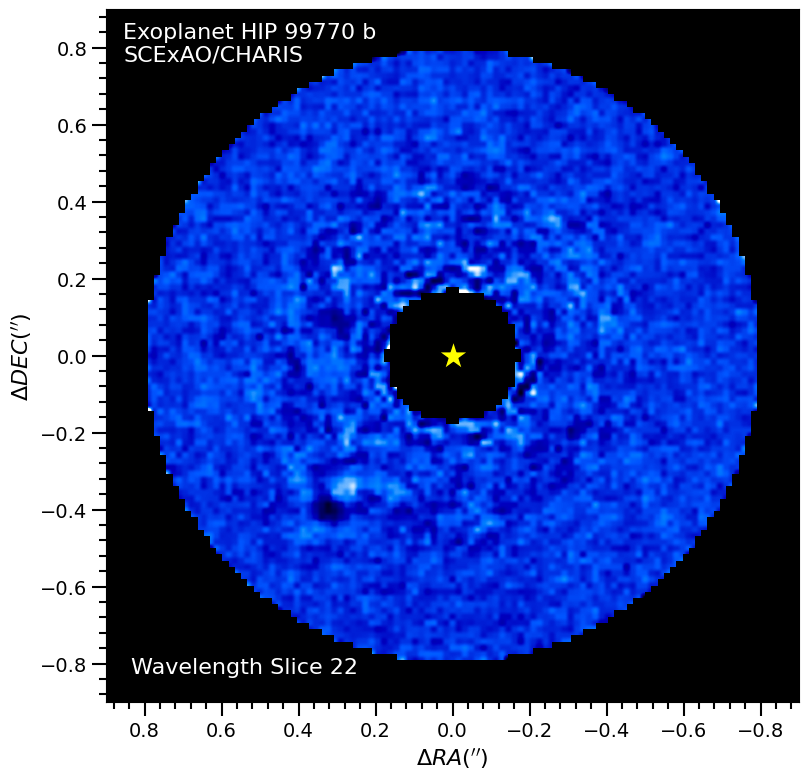

In [7]:
cmapval = create_colormap('gist_heat')
fig, axes, fullext_image = setup_plot(rmax, pixelscale, data_cube.shape)
ani = create_animation(fig, axes, data_cube, cmapval, rmax, fullext_image, vertical_offset, horizontal_offset)
ani.save('exoplanet_hip99770b.gif', writer='pillow', fps=10)
ani.save('exoplanet_hip99770b.mp4', writer='ffmpeg', fps=10)

# Problem 6: Astropy Tables

### Appears to be MRT
The table appear to be in mrt format. I've specficed the format type in the code below.
1. Read in table
2. Reverse mod
3. calculate abs Hmag
4. specify formats
5. Write
6. check


In [8]:
table = ascii.read('leggett.txt',format='mrt')


mu = -table['M-m']
distance = 10 **((mu+5) / 5) #distance calculation

#assign it to the new column
table['Distance'] = distance

#H band mag without rounding yet
table['abs Hmag'] = table['Hmag'] - mu

#relevent columns for new table
updated_table = table['Name', 'Distance', 'Hmag', 'abs Hmag']

#formats for saving, both 2 decimals
formats = {'Distance': '%.2f', 'abs Hmag': '%.2f'}

#write to .tex
ascii.write(updated_table, 'newleggett.tex', format='latex', formats=formats, overwrite=True)

In [9]:
# 'read it back in to make sure its all good'
ascii.read('newleggett.tex')


Name,Distance,Hmag,abs Hmag
str17,float64,str14,float64
--,--,$\mathrm{mag}$,--
SDSS 0000+2554,--,14.74,--
SDSS 0001+1535,--,14.4,--
SDSS 0002+2454,--,16.09,--
LHS 102BC,9.55,12.14,12.24
LHS 102A,9.55,8.02,8.12
SDSS 0016-0043,--,15.34,--
BRI 0021-0214,11.86,11.1,10.73
2MASS 0028+1501,--,15.48,--


In [10]:
#read in new table file
data = ascii.read('newleggett.tex')

#filter entries for numerical distance values
valid_distances = data['Distance'][data['Distance'] > 0.00001]

#assign distances as unit parsec
distances_pc = valid_distances * u.pc


#Problem 7: Read in table, plot routine + extra credit
1. Read in new table `newleggett.tex`
2. Assign Units to distances (parsec)
3. Function to plot, passed distances & target unit
4. Function call to plot for extra credit

In [11]:
def plot_distance_histogram(distances, target_unit):
    """
    plots a histogram of distances in the specified unit.

    passed:
    distances: astropy numbber + unit
    target_unit (Unit): The unit to convert distances into for plotting.
    """
    #convert given distances to target unit
    distances_converted = distances.to(target_unit)

    #fig ax call
    fig, ax = plt.subplots()

    #plot step histogram with converted distance
    ax.hist(distances_converted, bins='auto', histtype='step')


    #axis labels
    ax.set_xlabel(f"Distance [{target_unit}]")
    ax.set_ylabel("Relative Number")


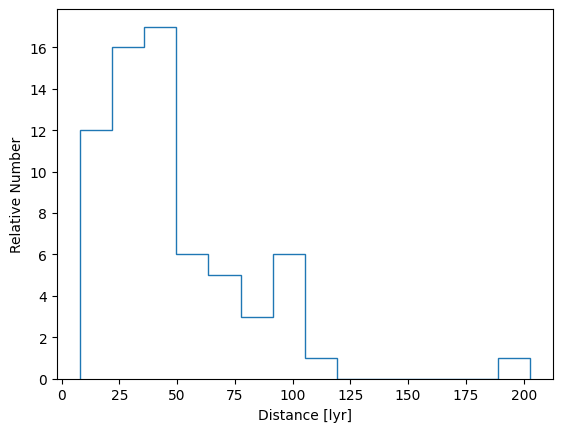

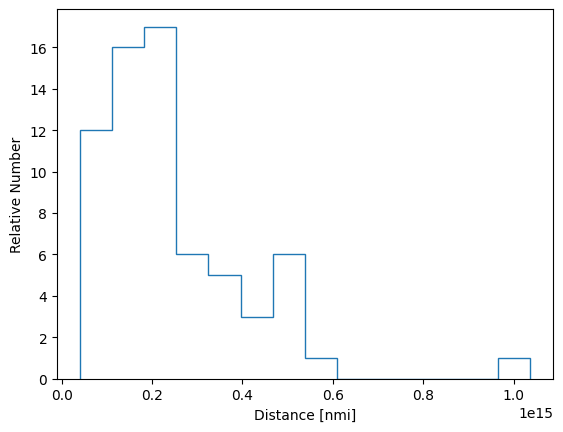

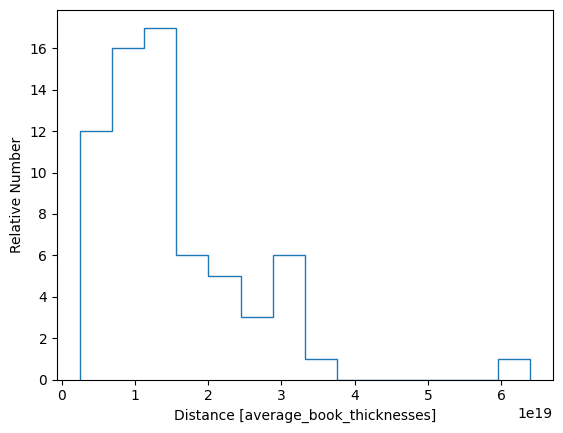

In [12]:
#function calls, source distance (pc), and desired unit

plot_distance_histogram(distances_pc,u.lyr)
#plot_distance_histogram(distances_pc,u.km)


#fun w/ other units
#convert and plot in nautical miles
plot_distance_histogram(distances_pc, imperial.nmi)


#how many me heights away are they?
book_thicknesses = u.def_unit('average_book_thicknesses', 0.03 * u.meter)

#plot in book thicknesses heights
plot_distance_histogram(distances_pc, book_thicknesses)



In [13]:

#do summary of lecture

